# 信息瀑布实验模拟
模拟实验，探索最优策略
   
  
> 杨宇昊
>
> https://github.com/QSCTech-Sange/Information-Cascade-in-Python
>
>在主页上下载Slides记得浏览顺序是**能下则下，否则向右**。

## 引入库
我们需要`numpy`来加速随机数的生成以及列表的处理。


使用`pandas`来以列表的形式记录实验结果。


使用`matplotlib`来可视化结果。

如果没有的话请使用`pip install package_name`来安装。

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fractions
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 定义类
采用面向对象的程序设计思想，来尽可能降低代码的阅读难度。

基于同样的目的，对于类的内部变量也没有封装。

## 球
我们只需要定义一个内部变量颜色。

In [23]:
class Ball:
    def __init__(self, color):
        self.color = color

## 杯子
我们需要根据杯子的颜色来建立杯子，还要定义里面装了三个球，球的颜色按照实验的要求。


除了构造函数以外，定义了一个`pick()`函数，表示从杯子里随机抽一个球。返回的结果是字符串，表示颜色。

In [24]:
class Cup:
    def __init__(self, color):
        self.color = color
        if color == 'Red':
            self.balls = np.array([Ball('Red'), Ball('Red'), Ball('Blue')])
        else:
            self.balls = np.array([Ball('Red'), Ball('Blue'), Ball('Blue')])

    def pick(self):
        return self.balls[np.random.randint(0, 3)].color

## 杯子集合
总共有两个杯子，一红一蓝。杯子集合就是这么定义了。

还有一个函数`random_pick()`表示随机抽选一个杯子。返回的对象是`Cup`。

其实也可以不要这个类，直接写在`test`函数中也可，看哪种方便你理解了。

In [25]:
class Cups:
    def __init__(self):
        self.Cups = np.array([Cup('Red'), Cup('Blue')])

    def random_pick(self):
        return self.Cups[np.random.randint(0, 2)]

## 人
人的构造函数要指定一个`order`，即这个实验中给定的次序。因为不同的次序所作出的决策是不同的。

人的内部变量有次序，有抽到的球的颜色，有选择的颜色，还有选择的是否正确(和杯子颜色相同)。

**其中要值得关注的是`decide(info)`函数**。这表示了你所定义了的人的策略行为。它需要一个`info`，表示前人的选择结果。你可以随意改变其中的策略，来观察结果。`method`代表第几个方法。我预置四种方法，第一种是优先考虑个人最优的方法（即个人的正确率最大），第二种是优先考虑群体最优的方法。
第三种用于个人最优的对照。

In [5]:
class Person:
    def __init__(self, order, Cup):
        self.order = order
        self.choice = None
        self.right = False
        self.cupcolor = Cup.color
        self.picked = Cup.pick()

    # TODO：feel free to add methods
    def decide(self, info, method):
        if method == 1:  # 优先考虑个人最优的情况
            # 前两人选择自己抽到的颜色
            if self.order == 1 or self.order == 2:
                self.choice = self.picked
            # 后人根据前两人来选择自己的颜色
            else:
                if info[self.order-2] == info[self.order-3]:
                    self.choice = info[self.order -2]
                else:
                    self.choice = self.picked
        if method == 2:  # 优先考虑最后一人最优的情况
            if self.order != 6:
                self.choice = self.picked
            else:
                info.append(self.picked)
                if info.count('Red') > info.count('Blue'):
                    self.choice = 'Red'
                else:
                    self.choice = 'Blue'

In [26]:
    # 接上一张    
    if method == 3:  # 作为一的对照组
            # 前三人选择自己抽到的颜色
            if self.order <= 3:
                self.choice = self.picked
            # 后人根据前三人来选择自己的颜色，完全不看自己的颜色
            else:
                info_temp = info[-3]
                if info_temp.count('Red') > info_temp.count('Blue'):
                    self.choice = 'Red'
                else:
                    self.choice = 'Blue'
        if method == 4: # 前两人按照自己的选，后面人根据前面的人选，如果前面的总人数五五开，按照自己的选，否则按照前面的人选。
            if self.order == 1 or self.order == 2:
                self.choice = self.picked
            else:
                if info.count('Red') > info.count('Blue'):
                    self.choice = 'Red'
                if info.count('Red') < info.count('Blue'):
                    self.choice = 'Blue'
                else:
                    self.choice = self.picked
      # if method == 5 :
            # it's your'turn now!
        
    def strategy(self, info, method):
        self.decide(info, method)
        if self.choice == self.cupcolor:
            self.right = True

# 策略分析

对于 method 1 而言 ——
1. 当我所在的位置是第一个人的时候，我会选择自己抽到的颜色。显然，我的正确率有`2/3`。

2. 当我所在的位置是第二个人的时候，我还是会选择自己抽到的颜色。因为如果我和前人颜色相同必选前人，答对的概率为`4/5`。而不同的时候，我选哪种颜色的概率都是`1/2`。为了告诉下一个人我和前人颜色不同，所以坚守自己的颜色可以更偏向群体最优。

3. 当我所在的位置是第三个人的时候，如果前两人颜色相同，我会跟从他们的选择。如果两人颜色不同，我会坚定自己的选择。为什么是这样的结果？这是我经过概率论的推导得出的。

4. 当我所在的位置是第四个人的时候，如果前两人颜色相同（即第三个人也相同），我会选择相同的颜色。如果两人颜色不同，我会选择自己的颜色。

5. 当我所在的位置是第五人的时候，如果三四两人颜色相同，跟从他们的选择。如果三四两人颜色也不同，坚守自己的选择。

6. 当我所在的位置是第六人的时候，如果四五人颜色相同，跟从他们的选择。如果四五人颜色不同，坚守自己的选择。


总的说来，就是前两人选自己的颜色，后面的人根据前两人是否相同而选择是否跟从他们。注意，必须人人按照这个规则，才可能得到最优群体解（最后一个人概率最大）。如果中间有一人打破，那么下一个人的最优解会发生变化。这经过了复杂而严密的推导——因为到后期所发生的分支实在是太多了。

是不是越往后越绕，越乱？是时候更改代码验证你自己的策略啦！

`method==2`时候的策略是前面五个人都遵照自己的意思，第六个人来判断，很明显是一种对最后一人最优的情况。

`method==3`时候的策略是对于第一种策略的怀疑，可能你会觉得要前三个人都相同我才能更好地符合个人理性。是这样吗？我们实验来证明。

你可能会怀疑，因为第四人或第三人的策略已经将前人的全部策略考虑进去了，所以我们更关注接近次序后面的人的选择。

`method==4`时候的策略前两人按照自己的选，后面人根据前面的人选，如果前面的总人数五五开，按照自己的选，否则按照前面的人选。


我知道你可能仍然在怀疑，而它已经列入`method==5` 里了。

## 单次Test 
`Test`类代表一次实验，需要传递杯子集合，然后抽取一个杯子。接着，自身创建一个人群，人群包含6个人。最后还需要一个信息集。信息集记录前面人的选择。
`Test`的核心函数是`test()`，每一个人根据策略选择，然后添加进`info`当中。`test_result()`返回了选择的结果，是一个`dataframe`类型。最后一个`print_result()`函数只是单纯为了检验`Test`类写得是否正确，是可以被删去的。

In [6]:
class Test:
    def __init__(self, Cups):
        self.cup = Cups.random_pick()
        People = []
        for i in range(1, 7):
            People.append(Person(i, self.cup))
        self.People = np.array(People)
        self.info = []
        
    def test(self,method):
        for i in range(0, 6):
            self.People[i].strategy(self.info,method)
            self.info.append(self.People[i].choice)

    def test_result(self,rounds,method):
        self.test(method)
        data = pd.DataFrame([[rounds, 1, self.People[0].picked, self.People[0].choice, self.People[0].right]])
        for i in range(1, 6):
            choice = pd.DataFrame([[rounds, i + 1, self.People[i].picked, self.People[i].choice, self.People[i].right]])
            data = data.append(choice)
        return data
    
    def print_result(self):
        print("Cup Color " + self.cup.color)
        print("Person id " + "  pick " + " claim " + " correct? ")
        for i in range(0, 6):
            print("     " + str(i) + "      " + self.People[i].picked + "   " + self.People[i].choice +  "   " + str(self.People[i].right))

### 检验代码是否正确
先检验一次实验的结果。下面代码可以反复运行，看看实际结果是否符合我们要求的结果。这里使用的是Medthod 1。

In [7]:
cups = Cups()
test = Test(cups)
test.test(1)
test.print_result()

Cup Color Red
Person id   pick  claim  correct? 
     0      Blue   Blue   False
     1      Red   Red   True
     2      Red   Red   True
     3      Red   Red   True
     4      Red   Red   True
     5      Red   Red   True


## Bingo!
接下来需要反复测试并统计结果。我们定义一个`Multi_test`类。

In [8]:
class Multi_test:
    def __init__(self, num, method):
        self.cups = Cups()
        self.data = pd.DataFrame(Test(self.cups).test_result(1,method))
        for i in range(1, num):
            self.data = self.data.append(Test(self.cups).test_result(i+1,method))
        self.data.columns=['round', 'order', 'picked', 'choice', 'right']

    def result(self):
        return self.data

## 检验代码是否正确
先检验一次实验的结果。反复测试输出的结果是否符合预期，这里简单重复100次实验，使用方法一。

In [9]:
test = Multi_test(100,1).result()
test.head(12)

,round,order,picked,choice,right
0,1,1,Red,Red,True
0,1,2,Red,Red,True
0,1,3,Blue,Red,True
0,1,4,Red,Red,True
0,1,5,Red,Red,True
0,1,6,Red,Red,True
0,2,1,Red,Red,True
0,2,2,Blue,Blue,False
0,2,3,Red,Red,True
0,2,4,Red,Red,True


## Bingo！
定义Medthod_Test,我们希望给定epoch和method，自动绘制出结果和显示比例。

我们需要什么样的统计结果呢？

我们需要看六个次序的不同的人，他们判断正确的人有多少。

In [10]:
class Method_Test:
    def __init__(self, method, epoch):
        Test = Multi_test(epoch, method).result()
        self.grouped = Test[Test['right'] == True].drop(['round', 'picked', 'choice'], axis=1).groupby('order').count()      
        self.epoch = epoch
        
    def plot(self):
        self.grouped.plot(kind='bar', ylim=(0, self.epoch), figsize=(13, 6))

    def ratio(self):
        self.grouped['right'] = self.grouped['right'] / self.epoch
        return self.grouped
        
    def ratio_whole(self):
        print(self.whole_right/epoch/6)

# 定义测试轮数
我们测试50000轮。使用`head()`函数来检查是否运行正确。50000这个数字可以随意更改。越大越精确，同时运行速度越慢。

In [11]:
epoch = 50000

## 方法一：
前两人选自己的颜色，后面的人根据前两人是否相同而选择是否跟从他们。

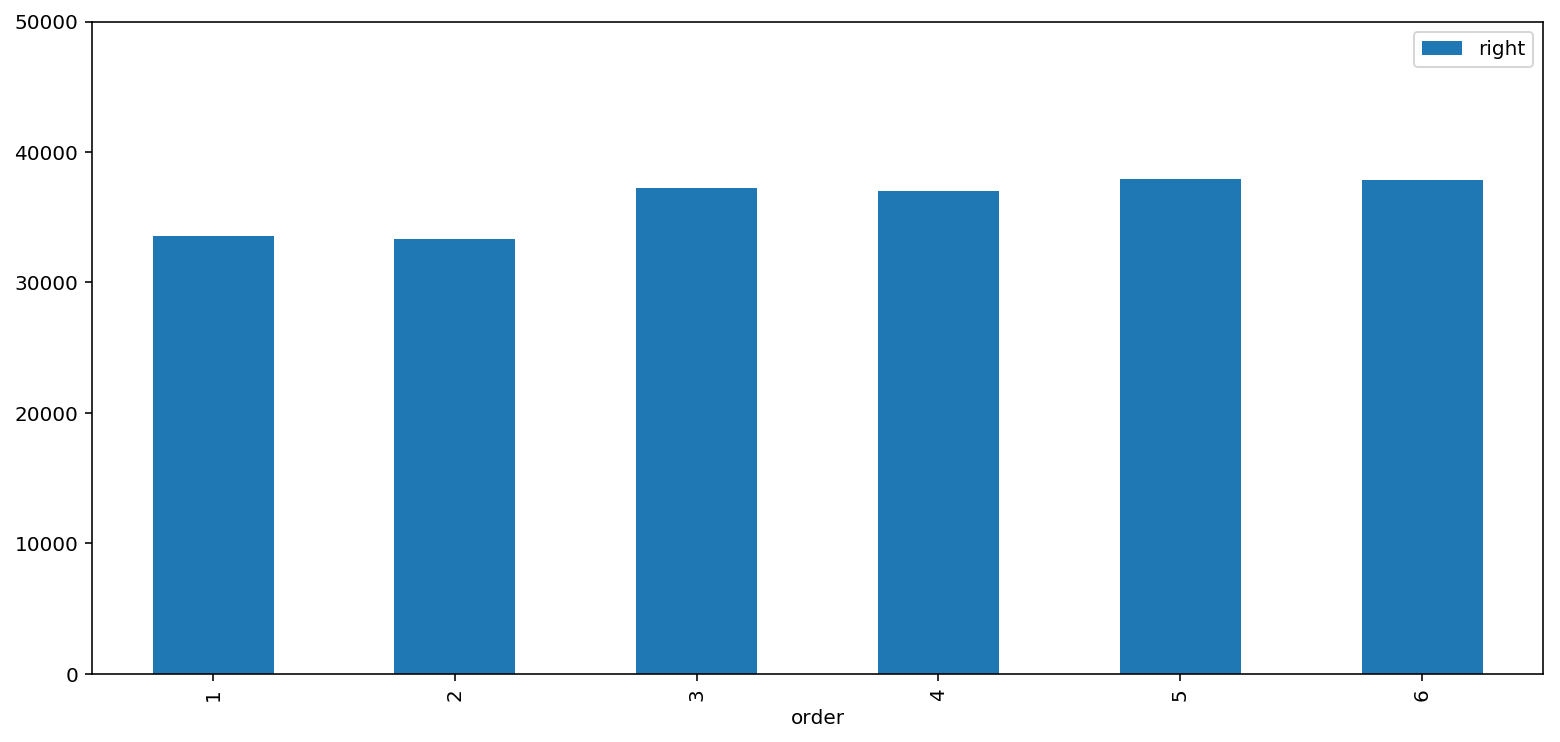

In [12]:
test_1 = Method_Test(1,epoch)
test_1.plot()

In [13]:
test_1.ratio().head(6)

,right
order,
1,0.67048
2,0.66668
3,0.74442
4,0.74054
5,0.75848
6,0.75766


In [14]:
test_1.ratio_whole()

order    0.723043
right    0.723043
dtype: float64


我们可以看到，排在第一二次序的人正确率是非常接近`2/3`的。从第二到第三的正确率大幅增加。在第三到第六次序依次几乎不变。我们用比例进行更好地展示。

这是一个使得自身正确率最大的策略。其中，所有人的准确率综合是大于0.72的。

# 对照其他组


## 方法二
`method==2`时候的策略是前面五个人都遵照自己的意思，第六个人来判断，很明显是一种对最后一人最优的情况。

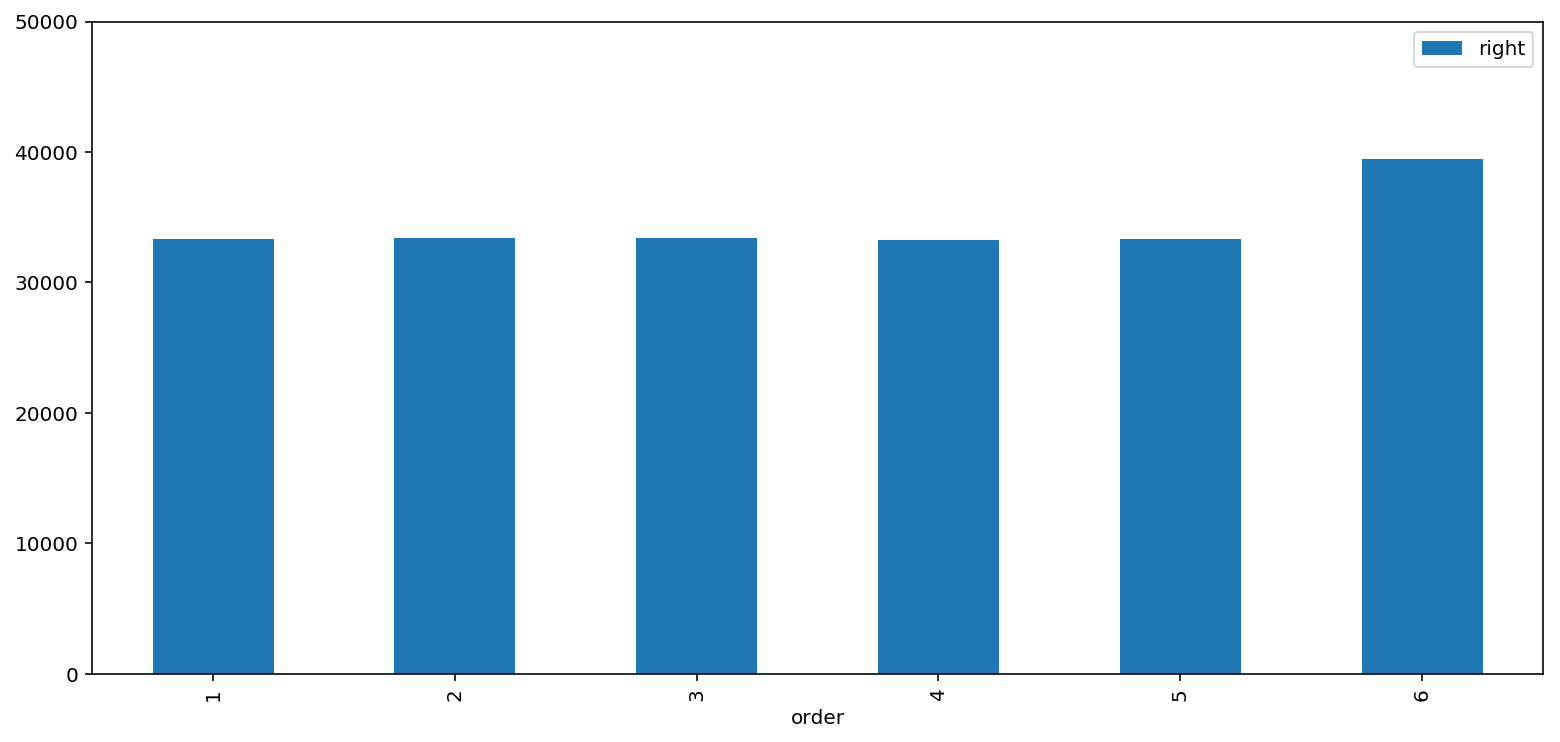

In [15]:
test_2 = Method_Test(2,epoch)
test_2.plot()

可以看到，这种策略的结果是前几位正确率在`2/3`左右，最后一位的结果大幅增加，符合我们的预期。

In [16]:
test_2.ratio().head(6)

,right
order,
1,0.66588
2,0.66790
3,0.66768
4,0.66538
5,0.66640
6,0.78910


In [17]:
test_2.ratio_whole()

order    0.687057
right    0.687057
dtype: float64


但是这种策略的综合正确率只有0.68左右。

## 方法三
`method==3`时候的策略是对于第一种策略的怀疑，可能你会觉得要前三个人都相同我才能更好地符合个人理性。

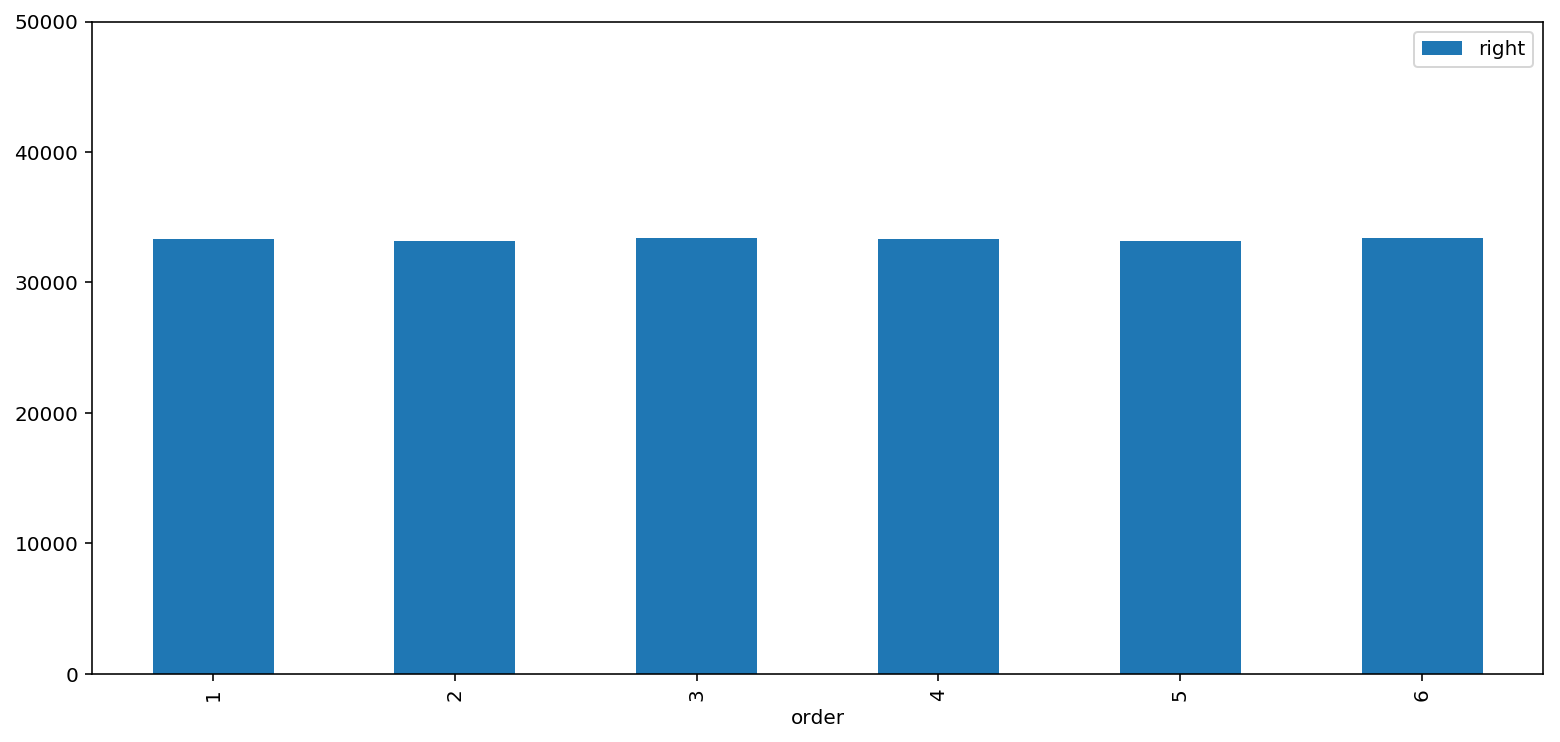

In [18]:
test_3 = Method_Test(3,epoch)
test_3.plot()

In [19]:
test_3.ratio().head(6)

,right
order,
1,0.66660
2,0.66432
3,0.66788
4,0.66660
5,0.66432
6,0.66788


In [20]:
test_3.ratio_whole()

order    0.666267
right    0.666267
dtype: float64


实验表明，这种策略看起来很美好，实际上让所有人的正确率都很低，和按照自己球颜色的一样，大家都是`2/3`的概率。

## 方法四
`method==4`时候的策略前两人按照自己的选，后面人根据前面的人选，如果前面的总人数五五开，按照自己的选，否则按照前面的人选。

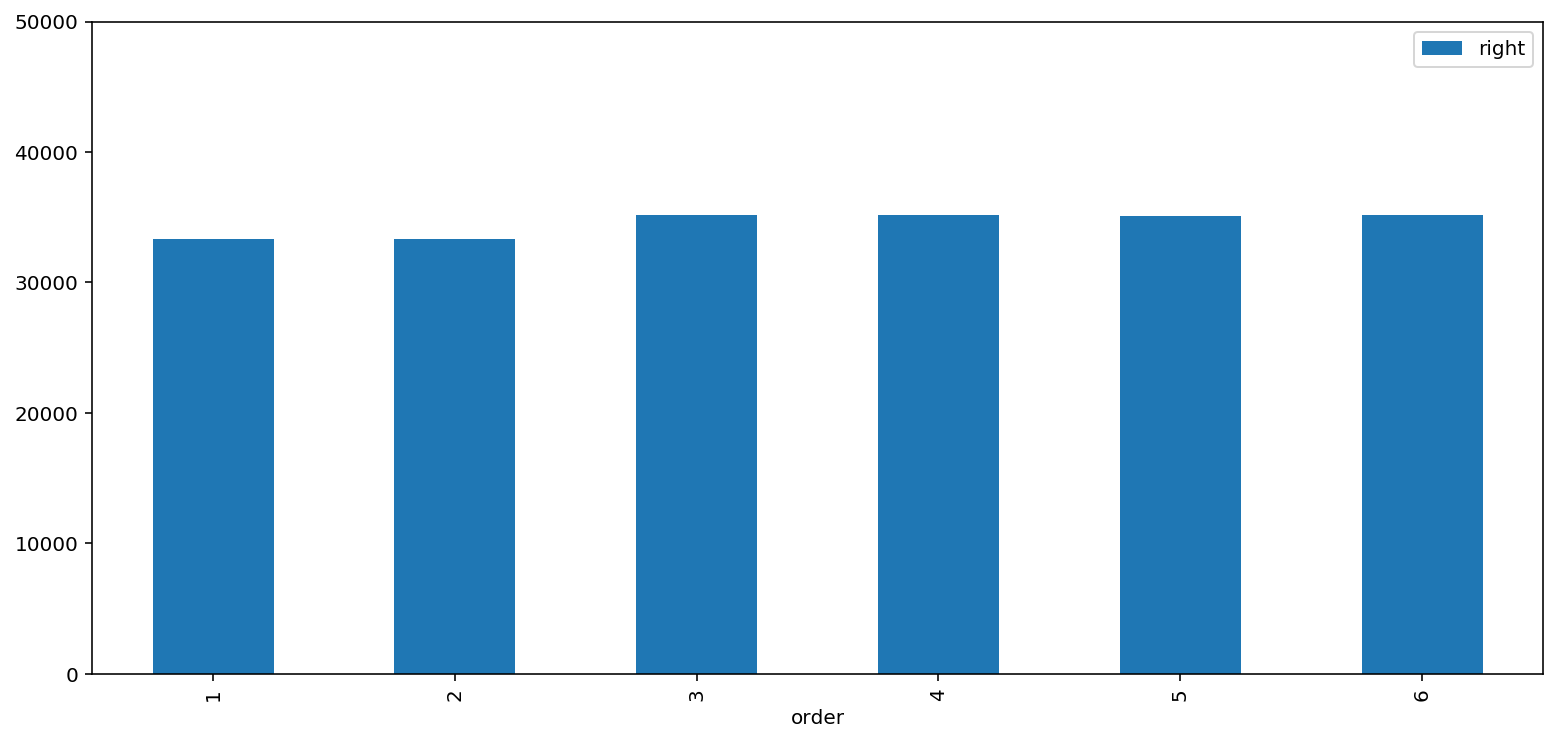

In [21]:
test_4 = Method_Test(4,epoch)
test_4.plot()

In [22]:
test_4.ratio().head(6)

,right
order,
1,0.66642
2,0.66666
3,0.70354
4,0.70320
5,0.70168
6,0.70378


In [23]:
test_4.ratio_whole()

order    0.69088
right    0.69088
dtype: float64


考虑了之前所有选择，被给予厚望的方法四效果仅仅比按照自己颜色选好了一点点。仅仅在第三个人身上有微小提升，其后人和第三人结果差异不大。

# One more thing ...

## 更好的测试方法？

我们可以利用**深度学习中的感知器神经网络**来自动最优化出最优参数。

方法是这样：
1. 首先将一种颜色定义为1，另一种定义为-1
2. 先只考虑第二人的情况。
3. 我们考虑三个变量，分别是第一个人的选择和自身所抽中的球的颜色，当然都是以1,-1表示的。
4. 任意给定两个权重，譬如0.25,0.75（按照假定，应该是越往后次序抽到的颜色权重越重要，所以这样假设，当然也可以随机假设）。这两者对应前面两个变量的系数，也就是权重。将这两个权重分别与前两个变量乘起来，得到的和，就是对于颜色的预测。预测值大于0代表大于1的颜色，小于0代表小于-1的颜色。还有一个bias可以理解为截距。
$$
w_1x_1 + w_2x_2+b = prediction
$$
5. 定义一个损失函数，代表预测颜色和实际颜色不一致的错误率。
6. 不断调整权重，使得预测结果尽可能地好。



如果拿第三个人来举例，如果第一个选择了红色(1)，第二个人选择了蓝色(-1)，你自己抽到了蓝色(-1)。初始化的权重是0.25,0.25,0.5。
所以你对于颜色的结果预测是

$$
    \hat{P} = 1 \times 0.25 + -1 \times 0.25 + -1 \times 0.5 = -0.5 < 0 
$$

小于0,即认为是蓝色。

损失函数通常使用交叉熵损失函数。它不仅衡量了猜对的个数，而且要求，颜色为0的预测结果越接近0的，比预测结果在0.4左右的更好。

$$
L(\hat{y},y) = -ylog(\hat{y}) - (1-y)log(1-\hat{y})
$$

在感知器模型当中，损失函数只是简单的

$$
   L(w,b) = - \sum_{x_i \in M} y_i(w \times x_i + b)
$$

调整权重的算法这里使用简单的单层感知器。使用随机梯度下降法，找到一个预测错的点，然后

$$
w=w+y_i\times x_i \times \eta
$$
$$
b = b + y_i \times \eta
$$

$\eta$是学习率，小于1。

# 图形示例
横坐标代表自身抽到的球的颜色，纵坐标代表上一个人声称的颜色。点的颜色是真实杯子的颜色。我们想要找到一根线，使得在这根线上面的都是红色的概率尽可能大，而下面的都是蓝色的概率尽可能大。

In [ ]:
X = np.array([[-1,-1],[-1,0.9],[1,0.9],[-1,1],[0.9,-0.9],[-0.9,-0.9],[-0.9,0.9],[1,-1],[0.9,0.9],[1,1],[1,0.9],[1,-0.9]])
x1,y1,x2,y2 = -1.1,1.2,1.1,-1.2
plt.scatter(X[:6, 0], X[:6, 1], color='blue',label = 'Blue cup')
plt.scatter(X[6:, 0], X[6:, 1], color='red',label = 'Red cup')
plt.plot([x1,x2], [y1,y2],'purple')
plt.xlabel('self.color')
plt.legend(loc = 'best')
plt.ylabel('last_one.color')
plt.title('Example')

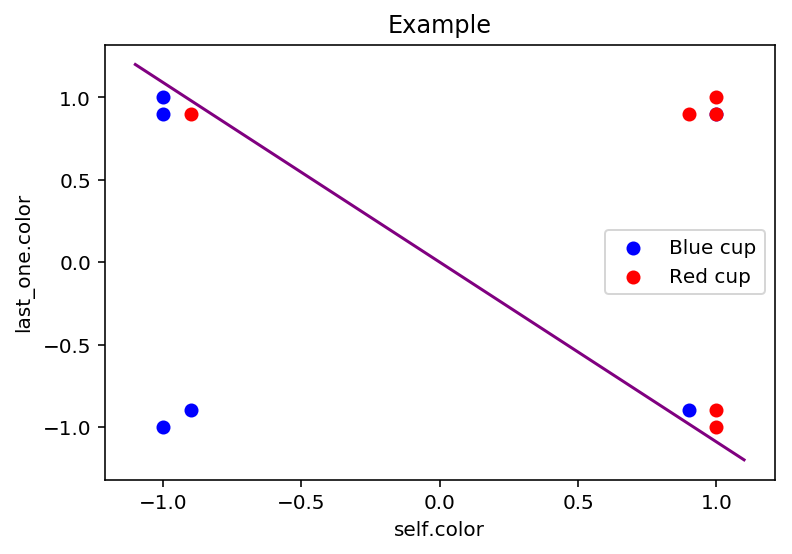

In [2]:
plt.show()

# 定义类 
定义球，杯子，杯子集合。

和之前几乎一样，除了颜色用1(Red),-1(Blue)来代替。

In [3]:
class Ball:
    def __init__(self, color):
        self.color = color

class Cup:
    def __init__(self, color):
        self.color = color
        if color == 1:
            self.balls = np.array([Ball(1), Ball(1), Ball(-1)])
        else:
            self.balls = np.array([Ball(1), Ball(-1), Ball(-1)])

    def pick(self):
        return self.balls[np.random.randint(0, 3)].color
    
class Cups:
    def __init__(self):
        self.Cups = np.array([Cup(1), Cup(-1)])

    def random_pick(self):
        return self.Cups[np.random.randint(0, 2)]

# 人
我们需要对人做一些改写。每次的策略实际上为

$$
    choice = sign(wx + b)
$$

$x$即info和自身抽到的球的颜色。$w$和$b$是要传递的权重和截矩。

构造函数很好理解。和上一篇一样。



In [4]:
class Person:
    def __init__(self, order, Cup):
        self.order = order
        self.choice = None
        self.right = False
        self.cupcolor = Cup.color
        self.picked = Cup.pick()

    def strategy(self, info, weight, bias):
        if self.order == 1:
            self.choice = self.picked
        else:
            x = np.array(info.copy())
            x = np.append(x,self.picked)
            self.choice = np.matmul(weight[self.order - 1],x.T) + bias[self.order - 1]
            self.choice = int(np.sign(self.choice[0]))
        if self.choice == self.cupcolor:
            self.right = True

`strategy(self, info, weight, bias)`是这样的，如果次序是1则所抽即所选。

是其他次序的话，需要用到权重和截矩。注意，这里的权重是一个二维数组，第一维记录的是给哪个次序的人的权重，第二位是真正的权重。比如对第二个人来说，他所利用到的权重就是weight\[1\]，而weight\[1\]里的内容假如为\[0.1,0.9\]，代表给第一个人的选择0.1的权重，给第二个人的选择为0.9的权重。

最后根据所选是不是真正的颜色来赋值一个布尔变量给right。

# 生成数据
每次生成数据需要指定杯子集合，指定生成多少行数据（一行为一次测试结果），指定最大的order。因为当我们要考察第二人的选择时，我们需要第一人的选择，第二人的预测值和实际的杯子颜色。此时的order_max = 1。weight是所有人的预测权重集合的集合。bias 是误差项的集合。最后的result()返回一个dataframe。

In [5]:
class GenerateData:
        def __init__(self, Cups, order_max, num, weight, bias):
            # 生成一行的数据
            for i in range(0, num):
                self.cup = Cups.random_pick()
                people = []
                info = []
                # 生成每一个人的数据
                for j in range(1,order_max + 1):                  
                    people.append(Person(j, self.cup))
                    people[j-1].strategy(info, weight, bias)
                    info.append(people[j-1].choice)
                info.append(Person(j,self.cup).picked)    
                info.append(self.cup.color)
                if i == 0:
                    self.data = pd.DataFrame([info])
                else:
                    self.data = self.data.append(pd.DataFrame([info]))
            # 定义列名
            column = []
            for i in range(1, order_max + 1):
                column.append("person_" + str(i)+"_choice")
            column.append("person_" + str(order_max + 1) + "_picked")
            column.append("truth")
            self.data.columns = column

        def result(self):
            return self.data

# 测试生成数据
假设order_max为1的时候，生成测试数据。此时weight和bias不重要，随便设，符合格式要求即可。


In [6]:
weight = np.array([[0],[0,0],[0,0,0],[0,0,0,0],[0,0,0,0,0],[0,0,0,0,0,0]])
bias = np.array([[0],[0],[0],[0],[0],[0]])
cups = Cups()
data = GenerateData(cups, 1, 10, weight, bias).result()
data.head(10)

,person_1_choice,person_2_picked,truth
0,-1,-1,-1
0,1,-1,1
0,1,1,1
0,1,-1,-1
0,1,-1,-1
0,1,-1,1
0,1,1,1
0,1,-1,-1
0,1,1,1
0,1,1,1


## 测试生成数据
假设order_max为2的时候，生成测试数据。此时weight和bias的第一项会纳入到第二个人的决策当中。这里随便给个[0.4,0.6]。


In [7]:
weight = np.array([[0],[0.4,0.6],[0,0,0],[0,0,0,0],[0,0,0,0,0],[0,0,0,0,0,0]])
bias = np.array([[0],[0],[0],[0],[0],[0]])
cups = Cups()
data = GenerateData(cups, 2, 10, weight, bias).result()
data.head(10)

,person_1_choice,person_2_choice,person_3_picked,truth
0,-1,-1,-1,-1
0,-1,-1,1,-1
0,1,-1,-1,-1
0,1,1,1,1
0,1,-1,1,1
0,-1,1,-1,1
0,-1,1,1,1
0,-1,-1,-1,-1
0,-1,1,1,1
0,1,1,-1,-1


## 构建模型
数据已经生成完成，接下来要开始构建一个用来训练的模型。给定data，会随机一个weight和bias。

我们设定为当两次训练的误差变动小于0.001时停止训练。

In [8]:
class Model:
    def __init__(self, data):
        self.data = data
        self.column = data.shape[1] - 1
        self.weight = np.random.rand(self.column)
        self.bias = np.random.rand()
        self.loss = 9999999
            
    # 打印损失和权重，用于每次训练后的返回数据
    def print_loss(self,i):
        weight_print = "["
        for k in self.weight:
            weight_print = weight_print + str(k) + " "
        weight_print += ']'
        print("loss = " + str(self.loss) + "; epoch = " + str(i + 1) + "; weight = " + weight_print + "; bias = " + str(self.bias))
    
    # 返回结果的权重和偏差
    def result(self):
        return self.weight, self.bias

In [ ]:
    # 接上一张
    def train(self, learn_rate, onPrint):
        # truth 是正确的杯子颜色集合
        truth = np.array(self.data.iloc[:, -1])
        # x 是变量的集合
        x = self.data.iloc[:, :-1]
        # epoch 是训练周期
        epoch = 0
        while (True):  # 循环内为一次训练过程
            
            # 根据权重计算预测值
            prediction = np.matmul(self.weight, x.T) + self.bias

            # 计算损失
            loss = np.exp(- np.matmul(truth, prediction.T) / len(self.data))
            # 打印损失
            if onPrint:
                self.print_loss(epoch)
            if abs(self.loss - loss) < 0.001:
                if not onPrint:
                    self.print_loss(epoch)
                break
            self.loss = loss
            
            # 找到分类错的那些点
            prediction_sign = np.sign(prediction)
            self.data['prediction_sign'] = prediction_sign
            mis = self.data[self.data['prediction_sign'] != self.data['truth']].copy()
            
            # 对权重和偏差进行更新
            for j in range(int(len(mis)/2)):
                mis.iloc[j, :-2] = mis.iloc[j, :-2] * mis.iloc[j, -1]
                self.weight = self.weight + mis.iloc[j, :-2] * learn_rate
                self.bias = self.bias + mis.iloc[j, -2] * learn_rate
            epoch += 1

## 测试你的模型
先以一个两维的作为测试。

In [12]:
weight = np.array([[0], [0, 0], [0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
bias = np.array([[0], [0], [0], [0], [0], [0]])
data = GenerateData(cups, 1, 5000, weight, bias).result()
model = Model(data)
model.train(0.001, True)

loss = 9999999; epoch = 1; weight = [0.522718659426755 0.22412109356623877 ]; bias = 0.29328225611946324
loss = 0.7957073948036792; epoch = 2; weight = [1.3787186594267138 -0.0978789064337615 ]; bias = 0.2712822561194632
loss = 0.6789331871333498; epoch = 3; weight = [2.2347186594266195 -0.41987890643376174 ]; bias = 0.2492822561194632
loss = 0.5792962031033825; epoch = 4; weight = [3.0907186594265252 -0.741878906433762 ]; bias = 0.22728225611946318
loss = 0.4942814658198222; epoch = 5; weight = [3.946718659426431 -1.0638789064337553 ]; bias = 0.20528225611946316
loss = 0.4217430843567781; epoch = 6; weight = [4.802718659426693 -1.3858789064337198 ]; bias = 0.18328225611946314
loss = 0.3598500884667678; epoch = 7; weight = [5.658718659426979 -1.7078789064336843 ]; bias = 0.16128225611946312
loss = 0.3070402123298235; epoch = 8; weight = [6.514718659427265 -2.029878906433649 ]; bias = 0.1392822561194631
loss = 0.26198046077804205; epoch = 9; weight = [7.370718659427551 -2.35187890643361

# 展示出我们的结果
我们尝试作图来看看最后的划分线落在哪里。

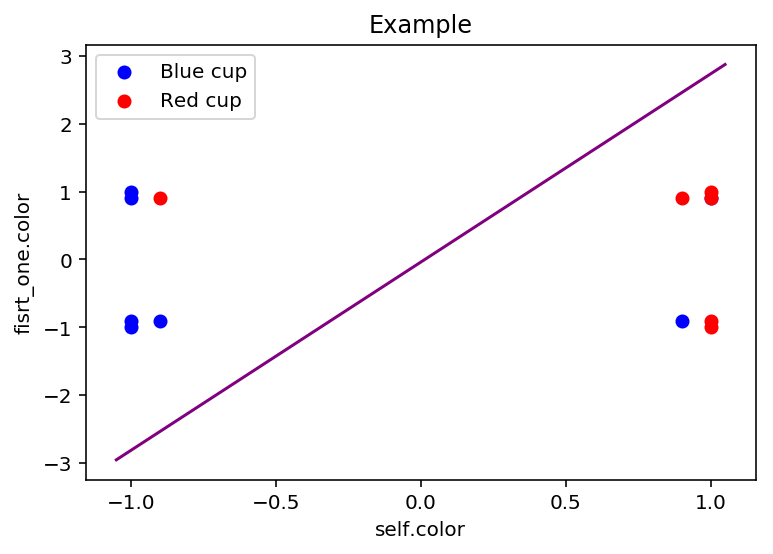

In [14]:
weight_1,bias_1 = model.result()
X = np.array([[-1,-1],[-1,0.9],[1,0.9],[-1,-0.9],[-1,1],[0.9,-0.9],[-0.9,-0.9],[-0.9,0.9],[1,-1],[0.9,0.9],[1,1],[1,0.9],[1,-0.9]])
plt.scatter(X[:7, 0], X[:7, 1], color='blue',label = 'Blue cup')
plt.scatter(X[7:, 0], X[7:, 1], color='red',label = 'Red cup')
y1 = - ( 1.05 * weight_1[0] + bias_1) / weight_1[1]
y2 = - ( -1.05 * weight_1[0] + bias_1) / weight_1[1]
plt.plot([1.05,-1.05], [y1,y2],'purple')
plt.xlabel('self.color')
plt.legend(loc = 'best')
plt.ylabel('fisrt_one.color')
plt.title('Example')
plt.show()

可以看得到，我们的直线还是有明显的分割数据的痕迹。Nice！

## 坐稳了吗？
维数要升上去了！

# 定义一个多轮测试的类
对每个次序的人都拟合出最优点。

In [15]:
class MultiTest:
    def __init__(self, num):
        self.num = num
        cups = Cups()
        self.weight = np.array([[0], [0, 0], [0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
        self.bias = np.array([[0], [0], [0], [0], [0], [0]])
        for i in range(1, 7):
            data = GenerateData(cups, i, num, self.weight, self.bias).result()
            print("order = " + str(i))
            model = Model(data)
            model.train(0.001, False)
            if i < 6:
                self.weight[i],self.bias[i] = model.result()
        self.data = GenerateData(cups, 6, num, self.weight, self.bias).result()
        
    def result(self):
        return self.data.drop(['person_7_picked'],axis=1)

# Attention! 
# 开始训练!

In [16]:
num = 5000
data = MultiTest(num)

order = 1
loss = 0.0053740649464186175; epoch = 26; weight = [-1.667127912577806 17.774981243724255 ]; bias = -0.3854440891543926
order = 2
loss = 0.003396749551628161; epoch = 21; weight = [5.709097332087547 5.428141869261497 6.783609292226206 ]; bias = -0.055487338514114776
order = 3
loss = 0.007179212294420562; epoch = 30; weight = [-7.401494004170759 24.921316142688994 3.8132722076384655 -6.974944545920083 ]; bias = 0.4089974769243818
order = 4
loss = 0.0017584611296297774; epoch = 14; weight = [-2.613256004258757 10.713057516431446 1.977985928125098 11.24107112198516 -2.508503085634685 ]; bias = 0.5360189777913564
order = 5
loss = 0.0011764328388640629; epoch = 10; weight = [-2.289737232446759 7.880304908893942 1.3955521063542213 7.882109443840587 8.133376049379367 -2.123123011419767 ]; bias = -0.09506235892376334
order = 6
loss = 0.001552018224907629; epoch = 7; weight = [-1.4929075727781236 5.707932447022737 0.9897890477499368 6.015289015240309 6.037258405985422 5.48212812860823

# 查看训练结果

In [17]:
result = data.result()
result.head()

,person_1_choice,person_2_choice,person_3_choice,person_4_choice,person_5_choice,person_6_choice,truth
0,-1,-1,-1,-1,-1,-1,-1
0,1,-1,1,-1,-1,-1,1
0,1,1,1,1,1,1,1
0,-1,1,-1,1,1,1,-1
0,-1,-1,-1,-1,-1,-1,-1


# 绘图

In [18]:
ratio = []
for i in range(1,7):
    string = 'person_' + str(i) + "_choice"
    temp = (len(result[result[string] == result['truth']]))/num
    ratio.append(temp)
ratio = pd.DataFrame(ratio,index = [1,2,3,4,5,6])
ratio.columns = ['correct ratio']
ratio

,correct ratio
1,0.6720
2,0.6604
3,0.7312
4,0.6604
5,0.6604
6,0.6604


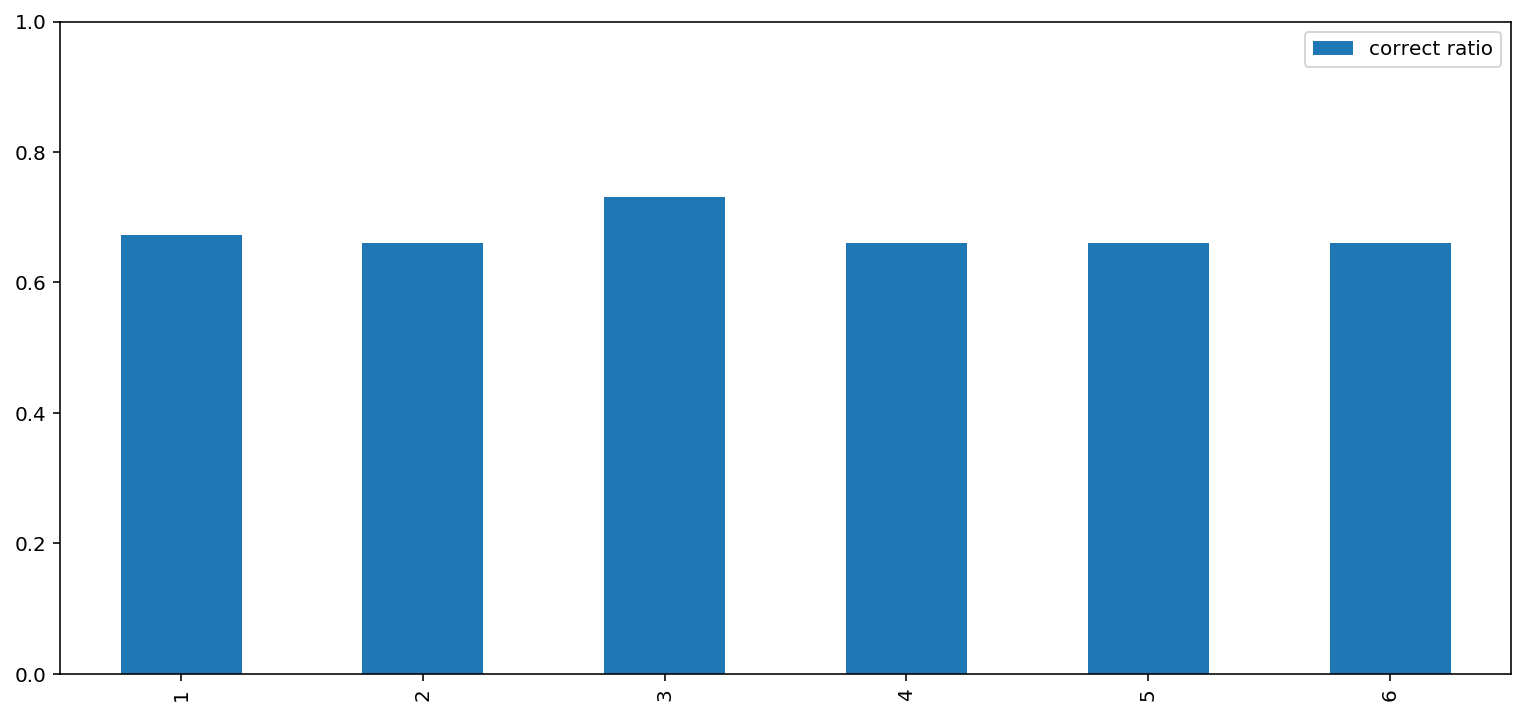

In [19]:
ratio.plot(kind='bar', ylim=(0, 1), figsize=(13, 6))

# 这就是神经网络
它并不比我们推导出来的最优解更好。

这是因为，我们的数据是线性不可分的，天然不是一个适合用神经网络的数据集。